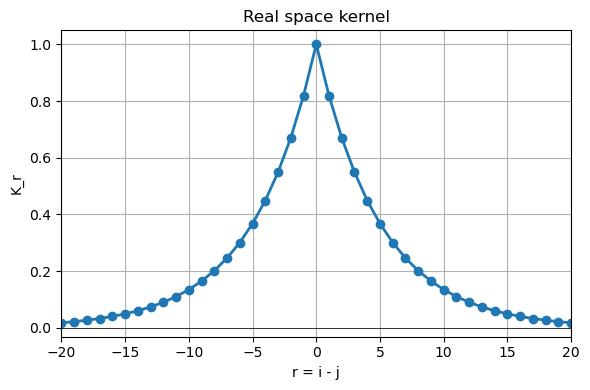

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from ewaldnn1d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "rough" # "smooth" or "rough"

N_grid = 512 # number of grid points
if data_regime == "smooth":
    M_cutoff = 50 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.2 * m)**2 # std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid - 1 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 10000
lr = 1e-2 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # padding mode for convolution-based routines: either "zero" or "reflect"
N_feat = 1 # number of local features per grid point

# interaction kernel parameters
kernel_regime = "exp"  # "power", "yukawa", or "exp", or "custom"

lam = 10.0
alpha = 1.0
xi = 5.0
amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy

if kernel_regime == "power":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="power", alpha=alpha)
elif kernel_regime == "yukawa": 
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="yukawa", lam=lam)
elif kernel_regime == "exp":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="exp", xi=xi)
elif kernel_regime == "custom":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="exp", xi=xi) + \
                amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode=pad_mode) + \
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode=pad_mode)
    
R = 20 
r_grid = torch.arange(-R, R+1)
plt.figure(figsize=(6,4))
if kernel_regime == "yukawa":
    plt.plot(r_grid, K_yukawa(r_grid, lam=lam), 'o-', linewidth=2) 
elif kernel_regime == "power":
    plt.plot(r_grid, K_power(r_grid, alpha=alpha), 'o-', linewidth=2) 
elif kernel_regime == "exp":
    plt.plot(r_grid, K_exp(r_grid, xi=xi), 'o-', linewidth=2)
elif kernel_regime == "custom":
    K_r = K_exp(r_grid, xi=xi) + \
          amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + \
          amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2)
    plt.plot(r_grid, K_r, 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
# plt.ylim((0.0, 1.0))
plt.title(f"Real space kernel")
plt.grid(True)
plt.tight_layout()
plt.show()


# generate train/test split
rho_train, d_rho_train, a_train = sample_density_batch(N_train, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)    # (N_val, N_grid)
features_train = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


In [19]:
ckpt_dir = "LearningNonLocalKernel_wLocConv_checkpoints"
flag_train = False  # set to True to train models

R_list = list(range(1, 31))

if flag_train:
    for R in R_list:

        if kernel_regime == "exp":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
        elif kernel_regime == "yukawa":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
        elif kernel_regime == "power":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"

        torch.manual_seed(1234) # for reproducibility

        model = KernelOnlyEnergyNN(
            R=R,
            pad_mode=pad_mode,
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
        )

        hist, best_epoch = train_with_early_stopping(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            max_epochs=N_epochs,
            patience=patience,
            min_delta=min_delta,
            ckpt_dir=ckpt_dir,
            run_name=run_name,
            learning_regime="window",
            N_grid=N_grid,
            device=device,
        )


   epoch  train_loss   val_loss
0      1   33.242110  22.744495
1      2   14.951847   9.966168
2      3    6.201354   4.138668
3      4    2.515869   1.712373
4      5    1.025041   0.694948


<Axes: title={'center': 'loc_window_kernel_30_rough_exp_xi5.0'}, xlabel='epoch'>

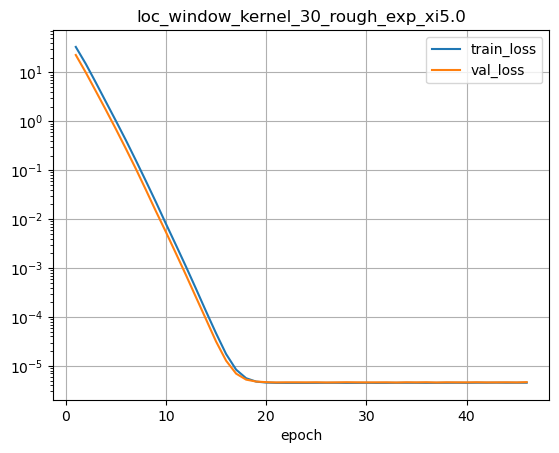

In [20]:
R = 30

if kernel_regime == "exp":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
elif kernel_regime == "yukawa":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
elif kernel_regime == "power":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"

path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

Model loc_window_kernel_1_rough_exp_xi5.0: best val loss = 0.466254 at epoch 10
Best model: R=1, val_loss=0.466254
Model loc_window_kernel_2_rough_exp_xi5.0: best val loss = 0.296872 at epoch 11
Best model: R=2, val_loss=0.296872
Model loc_window_kernel_3_rough_exp_xi5.0: best val loss = 0.219877 at epoch 11
Best model: R=3, val_loss=0.219877
Model loc_window_kernel_4_rough_exp_xi5.0: best val loss = 0.141545 at epoch 9
Best model: R=4, val_loss=0.141545
Model loc_window_kernel_5_rough_exp_xi5.0: best val loss = 0.090699 at epoch 10
Best model: R=5, val_loss=0.090699
Model loc_window_kernel_6_rough_exp_xi5.0: best val loss = 0.057667 at epoch 65
Best model: R=6, val_loss=0.057667
Model loc_window_kernel_7_rough_exp_xi5.0: best val loss = 0.038553 at epoch 11
Best model: R=7, val_loss=0.038553
Model loc_window_kernel_8_rough_exp_xi5.0: best val loss = 0.025717 at epoch 113
Best model: R=8, val_loss=0.025717
Model loc_window_kernel_9_rough_exp_xi5.0: best val loss = 0.019031 at epoch 48


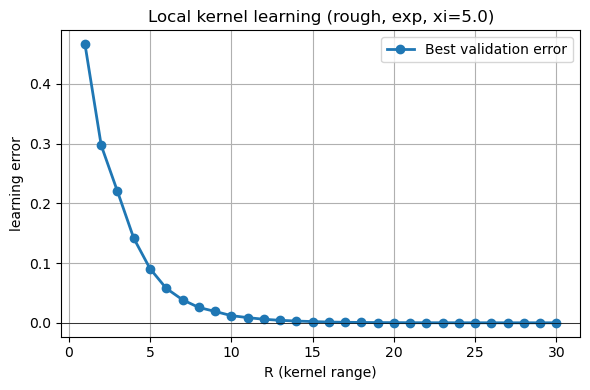

In [ ]:
R_best = 0
best_val = math.inf

val_hist_R = []
learning_hist_R = []

for R in R_list:
    if kernel_regime == "exp":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
    elif kernel_regime == "yukawa":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
    elif kernel_regime == "power":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"

    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

    val_hist_R.append((R, val_loss))
    learning_hist_R.append((R, ))

    print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
    if val_loss < best_val:
        best_val = val_loss
        R_best = R

    print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

print("Validation history:")
for R, val_loss in val_hist_R:
    print(f"R={R}: val_loss={val_loss:.6f}")

plt.figure(figsize=(6,4))
plt.plot([x[0] for x in val_hist_R], [x[1] for x in val_hist_R], 'o-', label='Best validation error', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("R (kernel range)")
plt.ylabel("learning error")
# plt.ylim((0.0, 1e-4))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
plt.tight_layout()
plt.show()


# data = np.column_stack([[x[0] for x in val_hist_R], [x[1] for x in val_hist_R]])
# np.savetxt(f"Figure_2/hist_loc_kernel_xi{xi}.txt", data)

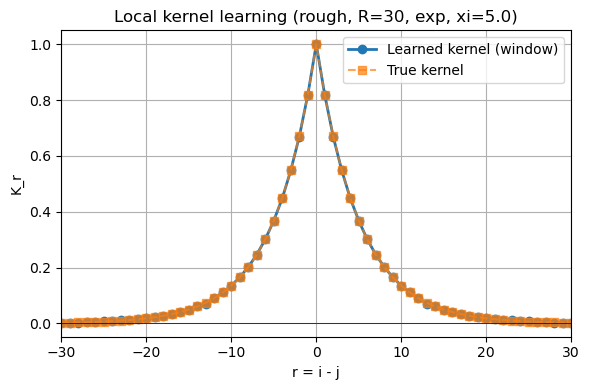

In [ ]:

R = 30
if kernel_regime == "exp":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
elif kernel_regime == "yukawa":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
elif kernel_regime == "power":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"
model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

with torch.no_grad():
    k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 

r_grid = np.arange(-R, R+1)

if kernel_regime == "exp":
    def K_true(r):
        return np.exp(-np.abs(r) / xi)
elif kernel_regime == "yukawa":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / lam) / np.maximum(r_abs, 1.0)
        return out * (r_abs > 0)
elif kernel_regime == "power":
    def K_true(r):
        r_abs = np.abs(r)
        out = 1.0 / (np.maximum(r_abs, 1.0)**alpha)
        return out * (r_abs > 0)    

k_true = K_true(r_grid)

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full , 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, power, alpha={alpha})")
plt.tight_layout()
plt.show()


# data = np.column_stack([r_grid, k_full])
# np.savetxt(f"Figure_2/loc_kernel_xi{xi}.txt", data)